# Lab 2: Exploring Image Data #

# 1 Business Understanding

## 1.1 Background

Facial recognition is used in a variety of ways within the tech industry. One example is Facebook's automatic tagging. When a user posts a picture of themselves and their friends, Facebook will look at the picture and tag any of the user's friends with their profile. No longer do users have to manually tag their friends on posts. Another use of facial recognition is identifying endangered species in the wild to protect them. With a collection of well-positioned cameras, park rangers and researchers are able to easily monitor wildlife remotely, and the use of facial recognition software allows them to automatically track the locations of endangered species as well as poachers. The popular use of facial modifications through the use of filters such as those found in the popular mobile application *SnapChat* demonstrate that this technology is a useful tool in social media and entertainment industry, as well.

Creating classification models for animal breeds provide a variety of uses. According to the American Humane Society, 10 million household pets are lost every year in the United States. Only a fraction of those pets end up in animal shelters, and many of them won't ever be reunited with their owners. Animal facial recognition technology can help pet owners find their lost pets in conjunction with the numerous public-facing cameras in city streets. Self-driving cars also greatly leverage the use of computer vision technology. Although car manufacturers are more concerened about human lives, animal-related car accidents and fatalities are not uncommon. Being able to identify a large moose on snowy Canadian roads could prevent major car accidents, and the ability to recognize a cat or dog on a road can prevent the loss of someone's pet. The usage of image recognition software is wide-ranging, but we know it is incredibly useful in today's world.

https://americanhumane.org/blog/every-day-is-tag-day-is-your-pet-protected/#:~:text=Each%20year%2C%20approximately%2010%20million,in%20the%20nation's%20animal%20shelters.

https://www.nathab.com/blog/self-driving-vehicles-could-save-animal-lives

## 1.2 Value Proposition

The cat and dog faces dataset is a subset of Cornell University's STARGan v2 dataset of high quality animal faces. These images are useful for solving image-to-image translation problems, where the goal is to learn the mapping between an input image and an output image. A practical application for this would be the use of computer-generated imagery in films and image-editing. Creating software that provides high qualilty, accurate, and fast image-to-image translation using these images can provide great value to the entertainment and other industries.

For our purpose, we are concerned with classifying these images and creating accurate captions. By generating accurate descriptions for these images as either cat or dog, we can help create better tools for animal shelters and wildlife protection organizations for in-depth animal identification tasks.

https://github.com/clovaai/stargan-v2

## 1.3 Measure of Success

Since there exists two different classes in our animal dataset, cat or dog, we expect our predictions to yield a nearly 100% success rate given inputs with the same quality of those within our dataset. The original purpose of the dataset was not image classification so we cannot create a measure of success based on a measure stated within the associated paper. But, as the classification task associated with the dataset will be binary, the classification must, at minimum, be better than coin flips yielding 50% accuracy.

## 1. Data Preparation

### 1.1 Data loading

* Each of our `cats` and `dogs` directories contain 2000 images of the said animal respectively (so 4000 images total)
* These images are loaded into their respective dataset containers, which for now will be a list of images
* To expedite our computatation, we will resize our images from 512 x 512 to 128 x 128 pixels

In [30]:
from typing import *
import cv2 # pip install opencv-python
import os 
import glob

def get_list_of_imgs(folder_path: str) -> List:
    data_path = os.path.join(folder_path,'*g') 
    files = glob.glob(data_path) 
    list_of_imgs = []
    lim = 500
    for f1 in files:
        img = cv2.imread(f1)
        img_resized = cv2.resize(img, dsize = (128, 128), interpolation = cv2.INTER_CUBIC)
        # img_resized = cv2.resize(img, dsize = (128, 128))
        list_of_imgs.append(img_resized)
    return list_of_imgs

list_of_cat_imgs = get_list_of_imgs('./cats')
list_of_dog_imgs = get_list_of_imgs('./dogs')

print(f'Loaded {len(list_of_cat_imgs)} cat images')
print(f'Loaded {len(list_of_cat_imgs)} dog images')

Loaded 2000 cat images
Loaded 2000 dog images


*   All images in our dataset are grayscaled since
  * Color is not the most prominent distinguishing attribute between a cat and a dog
  * Luminance is more important in distinguisnig visual features of an image
  * Doing so further reduces the computational complexity of our analyses by allowing us to interact with a number representing a pixel instead of a 3-length (for RGB values) or 4-length (for BGBA values) array
* In addition, we now contain all of our images within Numpy arrays instead of Python lists since Numpy arrays
  * Take up less space
  * Are faster in terms of performing mathematical operations on a large number of data, which certainly is the case for us since we are working with image data, which contain large number of elements (at least 1 per every pixel)

In [31]:
import numpy as np

def list_to_numpy_array(img):
    return np.asarray(img, dtype=np.float32)

def grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.144])

def grayscale_imgs(list_of_imgs):
    return list_to_numpy_array([grayscale(img) for img in list_of_imgs])

np_cats = grayscale_imgs(list_of_cat_imgs)
np_dogs = grayscale_imgs(list_of_dog_imgs)

Here, we ensure that all of our images are of the same size (i.e. are of the expected 126 x 128 dimensions)

In [32]:
def get_height(img):
    return len(img)

def get_width(img):
    return len(img[0])

def check_all_imgs_same_dimensions(imgs, animal_type):
    h = get_height(imgs[0])
    w = get_width(imgs[0])
    h_set = set()
    w_set = set()
    for img in imgs:
        h_set.add(get_height(img))
        w_set.add(get_width(img))
    all_heights_are_equal = len(h_set) == 1
    all_widths_are_equal = len(w_set) == 1
    all_same_dimensions = all_heights_are_equal and all_widths_are_equal
    if all_heights_are_equal and all_widths_are_equal:
      print(f'All {animal_type} images have same width and height ({w} x {h})')
    else:
      print(f'All {animal_type} images DO NOT have same width and height ({w} x {h})')

check_all_imgs_same_dimensions(np_cats, 'cat')
check_all_imgs_same_dimensions(np_dogs, 'dog')

All cat images have same width and height (128 x 128)
All dog images have same width and height (128 x 128)


### 1.2 Image visualization

To ensure that our images have been properly grayscaled, that their resizing have not significantly distorted their image quality, and to provide a visual basis from which we will process our images, we print the first 18 images in each of our dataset.

In [33]:
import matplotlib.pyplot as plt

def plot_gallery(images, titles=None, h=128, w=128, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles: plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

Gallery of Cats


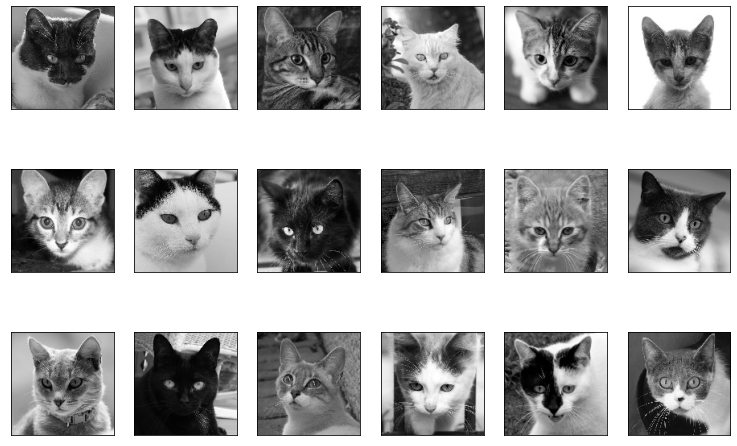

In [34]:
print('Gallery of Cats')
plot_gallery(np_cats)

Gallery of Dogs


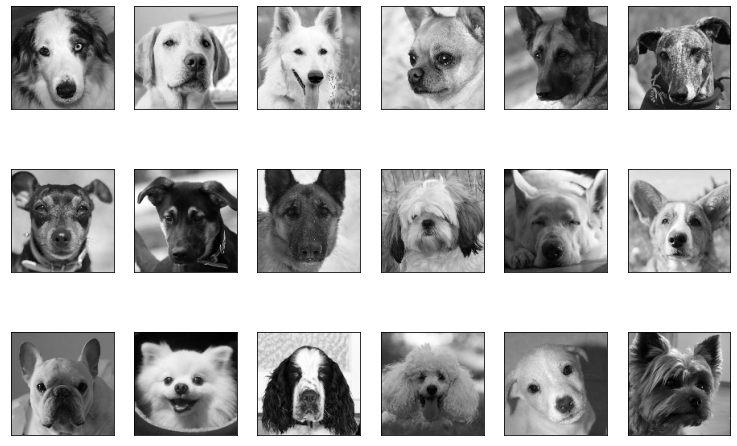

In [35]:
print('Gallery of Dogs')
plot_gallery(np_dogs)

### 1.3 Image linearization

To simplify the procedure of performing statistical analyses on our datasets, we flatten our images, meaning we take the currernt array of arrays data structure of every image (128 x 128) and turn it into a singe array of 16384 (= 128 * 128) pixels.

In [58]:
import pandas as pd
import numpy as np

def flatten(img):
  return img.flatten()

def apply_to_all(imgs, func):
    return list_to_numpy_array([func(img) for img in imgs])

flatten_cats = apply_to_all(np_cats, flatten)
flatten_dogs = apply_to_all(np_dogs, flatten)

df_cat = pd.DataFrame.from_records(flatten_cats)
df_dog = pd.DataFrame.from_records(flatten_dogs)

In [37]:
df_cat

0           1           2           3           4           5      \
0     162.397995  162.397995  162.397995  162.397995  162.397995  162.397995   
1     205.401993  208.492004  213.641998  220.852005  228.061996  234.242004   
2      47.990002   49.297001   59.132000   57.348999   59.098999   66.896004   
3     206.576004  206.576004  206.576004  206.576004  206.576004  207.750000   
4     123.846001  127.976997  134.179001  139.195999  144.223999  153.792999   
...          ...         ...         ...         ...         ...         ...   
1995  102.624001  102.624001  101.892998  103.953003  102.480003  103.222000   
1996   29.239000   29.239000   28.209000   28.209000   27.766001   27.766001   
1997  253.468002  238.250000  253.600998  255.815994  253.024994  246.024994   
1998   27.611000   63.328999   49.784000   42.452000   23.480000   20.400999   
1999   27.546000   25.785000   23.725000   22.407000   23.138000   23.004999   

           6           7           8           9      ...       16374  \
0     162.397995  162.397995  164.468994  162.408997  ...   53.118000   
1     236.302002  234.242004  231.727997  231.727997  ...  261.010986   
2      62.764999   59.077000   61.303001   67.183998  ...   34.046001   
3     210.828995  210.817993  213.000000  221.240005  ...  198.259003   
4     154.822998  163.794006  168.677994  171.623993  ...   73.176003   
...          ...         ...         ...         ...  ...         ...   
1995  100.585999   99.865997  101.947998   96.797997  ...  127.143997   
1996   29.826000   30.856001   32.916000   36.293999  ...   70.238998   
1997  235.613998  236.057007  232.380005  228.270996  ...  101.671997   
1998   17.909000   20.566999   17.610001   19.670000  ...   49.439999   
1999   24.788000   28.631001   26.482000   17.777000  ...  216.621002   

           16375       16376       16377       16378       16379       16380  \
0      62.233002   98.116997   98.404999   63.817001   88.824997   60.417000   
1     257.920990  214.384003  200.229996  132.072998  130.722000  137.643997   
2      26.138000   23.325001   23.181000   14.077000   16.148001   11.884000   
3     201.348999  201.194000  206.343994  205.313995  204.283997  202.201996   
4      74.051003   72.710999   78.304001   76.244003   78.304001   77.295998   
...          ...         ...         ...         ...         ...         ...   
1995  127.143997  128.173996  130.233994  130.233994  130.233994  128.317993   
1996   70.238998   72.309998   77.448997   92.301003  110.242996  129.647003   
1997   93.431999   69.154999   60.848999   52.742001   67.947998   80.773003   
1998   22.527000   23.546000   25.905001   24.000000  122.304001   17.941999   
1999  210.729004  200.705994  190.395004  181.856003  166.539001  156.272003   

           16381       16382       16383  
0      78.149002   71.871002   86.469002  
1     147.944000  152.063995  156.184006  
2      14.974000   27.334000   21.153999  
3     195.567993  198.348007  193.042999  
4      78.325996   80.386002   80.386002  
...          ...         ...         ...  
1995  128.317993  128.173996  128.173996  
1996  143.468994  156.250000  166.395004  
1997   97.086998   46.451000   18.209000  
1998   16.912001   18.972000   20.002001  
1999  152.727997  136.082001  126.656998  

[2000 rows x 16384 columns]

In [38]:
df_dog

0           1           2           3           4           5      \
0      47.714001   48.743999   48.743999   48.743999   49.773998   49.773998   
1     190.128006  190.272003  191.003006  190.559998  192.464996  192.320999   
2     140.912003  138.253998  137.212997  133.824005  131.044006  129.880997   
3     184.391998  183.063004  179.375000  178.632996  176.572998  176.572998   
4     193.940994  190.419006  186.011002  181.602997  180.274002  177.339005   
...          ...         ...         ...         ...         ...         ...   
1995    4.552000    4.552000    3.522000    3.522000    4.552000    4.552000   
1996   13.999000   19.149000   13.999000    6.789000   16.490999   19.282000   
1997  100.609001  101.639000  103.698997  105.759003  103.112000  104.873001   
1998   29.416000   29.416000   29.416000   27.356001   27.356001   27.356001   
1999  158.710007  163.615997  165.709000  161.001999  157.934006  145.130997   

           6           7           8           9      ...       16374  \
0      50.804001   49.773998   51.834000   51.834000  ...  146.968994   
1     192.619995  193.063004  195.123001  195.123001  ...  182.662994   
2     130.789001  130.800003  131.830002  128.917007  ...  120.044998   
3     179.662994  180.692993  182.908005  183.938004  ...  168.246002   
4     175.589005  174.869003  172.664993  167.957993  ...   72.543999   
...          ...         ...         ...         ...  ...         ...   
1995    4.552000    4.552000    4.696000    4.696000  ...   46.716999   
1996   14.708000   22.649000   24.542999   30.590000  ...   67.704002   
1997  103.843002  107.962997  104.019997  109.169998  ...  196.276001   
1998   25.296000   22.205999   21.774000   22.804001  ...   91.106003   
1999  125.362000   93.355003   68.767998   51.269001  ...   38.110001   

           16375       16376       16377       16378       16379       16380  \
0     146.968994  148.298004  143.878998  142.848999  143.878998  146.968994   
1     183.692993  185.177002  185.177002  185.177002  185.177002  185.753006   
2      77.871002  106.081001  111.129997   79.044998   82.100998   72.555000   
3     169.707993  163.804993  160.261002  150.371002  146.970993  140.348007   
4      71.823997   81.060997   75.612000   79.421997   87.064003   81.471001   
...          ...         ...         ...         ...         ...         ...   
1995   37.458000   36.294998   33.205002   33.958000   34.999001   31.322001   
1996   71.823997   68.568001   71.657997   69.154999   70.184998   70.495003   
1997  201.425995  204.526993  204.526993  205.557007  204.227997  202.466995   
1998  109.945000  119.359001  122.448997  126.569000  133.779007  139.371994   
1999   39.139999   41.653999   49.894001   50.924000   48.863998   53.560001   

           16381       16382       16383  
0     147.998993  142.848999  130.488998  
1     184.136002  185.453995  185.453995  
2      91.504997   96.410004   68.279999  
3     138.287994  148.587997  158.744003  
4      82.821999   87.274002   72.444000  
...          ...         ...         ...  
1995   35.442001   37.501999   44.712002  
1996   70.495003   69.464996   71.525002  
1997  201.436996  201.436996  199.376999  
1998  140.701004  140.412994  142.339996  
1999   39.139999   44.290001   38.110001  

[2000 rows x 16384 columns]

# 2 Data Reduction

## 2.1 Dimensionality Reduction with Principle Component Analysis Linear

In [39]:
# Reference: https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb ln 35
from sklearn.decomposition import PCA

animals = ['cat', 'dog']
np_animals = np.concatenate((np_cats, np_dogs), axis=0)
animal_data = np.concatenate((flatten_cats, flatten_dogs), axis=0)

X = animal_data
Y = np.concatenate((np.zeros(500), np.ones(500)), axis=0)

n_samples, n_features = X.shape
_, h, w = np_animals.shape
n_classes = len(animals)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {} by {}".format(h,w))

n_components = 1000
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X.copy())
eigenfaces = pca.components_.reshape((n_components, h, w))

n_samples: 4000
n_features: 16384
n_classes: 2
Original Image Sizes 128 by 128
Extracting the top 1000 eigenfaces from 4000 faces
CPU times: user 35.5 s, sys: 1.23 s, total: 36.8 s
Wall time: 10.7 s


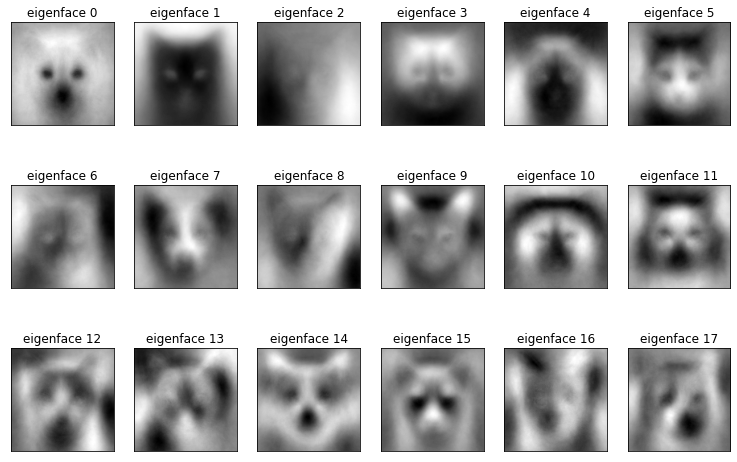

In [40]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [41]:
# Reference: https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb ln 8
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook

    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)

    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
        })
plot_explained_variance(pca)

## 2.2 Dimensionality Reduction with Randomized Principle Component Analysis Linear

In [42]:
n_components = 1000
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

rpca = PCA(n_components=n_components, svd_solver='randomized')
%time rpca.fit(X.copy())
eigenfaces = rpca.components_.reshape((n_components, h, w))

Extracting the top 1000 eigenfaces from 4000 faces
CPU times: user 35.4 s, sys: 1.21 s, total: 36.6 s
Wall time: 10.3 s


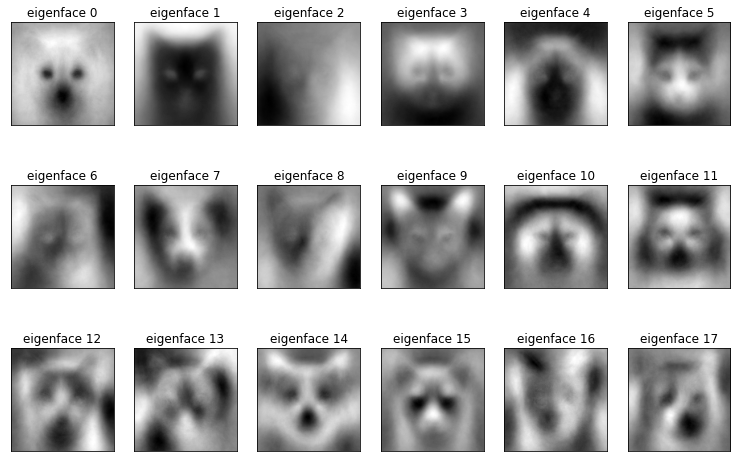

In [43]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

## 2.3 PCA vs Random PCA

In [44]:

from ipywidgets import widgets
import warnings

def plt_reconstruct(idx_to_reconstruct):
    # this code is for reference only, it does not qualify as a neaarest neighbor search
    #  for your lab project. 
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    x_flat = X[idx_to_reconstruct].reshape(1, -1)
    reconstructed_image = pca.inverse_transform(pca.transform(x_flat.copy()))    
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(x_flat.copy()))
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,3,1) # original
    plt.imshow(x_flat.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    plt.grid(False)
    
    plt.subplot(1,3,2) # pca
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid(False)
    
    plt.subplot(1,3,3) # randomized pca
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Randomized PCA')
    plt.grid(False)
    
    
    
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

interactive(children=(IntSlider(value=1999, description='idx_to_reconstruct', max=3999), Output()), _dom_class…

<function __main__.plt_reconstruct(idx_to_reconstruct)>

## 4 Feature Extractions

### 4.1 Basic statistics

* To explore our newly created dataframes, we will examine the mean, standard deviation, skew, and kurosis of our cat and dog dataframes. 
  * The purpose of this analysis is to see if there are significant differences between these statistics between our dataframes so that if such were to be the case, we may pursue the route of distinguishing our cat and dog images by performing Gabor filter Banks texture classification.
  * This idea initially arose from our impression that since some cats tend to have striped fur and most dogs do not, such distinction may materialize in the form of differences in the mean, standard deviation, skew, and/or kurosis between our respective datasets. Of course, there are cats who do not have any stripes either, so this exploration also serves as a way to affirm or disconfirm our aforementioned impression 

In [45]:
# statistics of pixel values
def generate_df_stat(df):
    df_stat = pd.DataFrame()
    df_stat['mean'] = [df.iloc[i].mean() for i in range(len(df))]
    df_stat['std'] = [df.iloc[i].std() for i in range(len(df))]
    df_stat['skew'] = [df.iloc[i].skew() for i in range(len(df))]
    df_stat['kurtosis'] = [df.iloc[i].kurtosis() for i in range(len(df))]
    return df_stat

In [46]:
df_stat_cat = generate_df_stat(df_cat)
df_stat_dog = generate_df_stat(df_dog)

In [47]:
df_stat_cat

mean        std      skew  kurtosis
0     102.848258  56.002235  0.109122 -0.917108
1     146.819609  64.915296 -0.401027 -0.776077
2      70.539296  36.818802  0.579659 -0.284943
3     147.162964  62.607674 -0.187510 -1.217723
4     119.435058  69.391277  0.486158 -0.818703
...          ...        ...       ...       ...
1995  121.066672  30.963653  0.059908  0.367089
1996   75.434542  47.948256  1.001773 -0.269525
1997  103.969150  71.272255  0.592832 -0.828797
1998   86.702946  84.634841  0.839532 -0.985052
1999  143.294353  85.435400 -0.226425 -1.542525

[2000 rows x 4 columns]

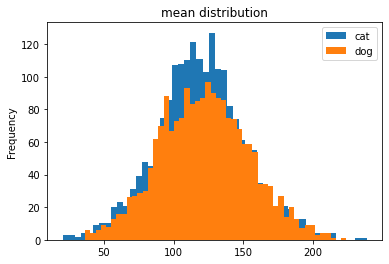

Cat mean stats:
count    2000.000000
mean      119.356759
std        31.701858
min        20.489342
25%        99.321436
50%       119.205559
75%       138.717546
max       238.412908
Name: mean, dtype: float64

Dog mean stats:
count    2000.000000
mean      122.139491
std        32.059819
min        36.638529
25%        98.707126
50%       121.686082
75%       144.067129
max       223.759450
Name: mean, dtype: float64
-----------------------------------------------


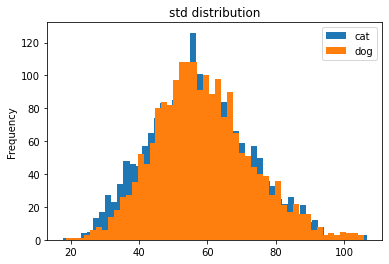

Cat std stats:
count    2000.000000
mean       57.716377
std        15.046697
min        17.603399
25%        46.806312
50%        56.812921
75%        67.528595
max       106.703306
Name: std, dtype: float64

Dog std stats:
count    2000.000000
mean       58.757155
std        14.120753
min        18.621368
25%        48.918472
50%        57.463673
75%        67.041024
max       105.926409
Name: std, dtype: float64
-----------------------------------------------


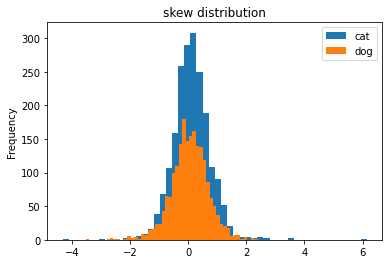

Cat skew stats:
count    2000.000000
mean        0.113842
std         0.646411
min        -4.330550
25%        -0.263515
50%         0.100137
75%         0.482197
max         6.149985
Name: skew, dtype: float64

Dog skew stats:
count    2000.000000
mean        0.042411
std         0.636713
min        -3.521341
25%        -0.328124
50%         0.052841
75%         0.444443
max         2.385784
Name: skew, dtype: float64
-----------------------------------------------


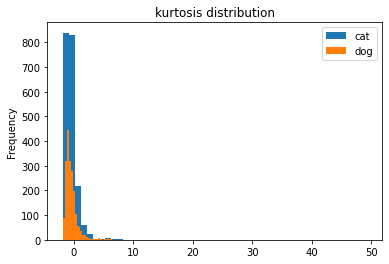

Cat kurtosis stats:
count    2000.000000
mean       -0.455764
std         1.794864
min        -1.926065
25%        -1.159168
50%        -0.773153
75%        -0.204047
max        49.273126
Name: kurtosis, dtype: float64

Dog kurtosis stats:
count    2000.000000
mean       -0.494170
std         1.193850
min        -1.915221
25%        -1.173731
50%        -0.762394
75%        -0.183505
max        14.797949
Name: kurtosis, dtype: float64
-----------------------------------------------


In [48]:
stat_features = ['mean', 'std', 'skew', 'kurtosis']

for feature in stat_features:
    df_stat_cat[feature].plot(kind='hist', bins=50)
    df_stat_dog[feature].plot(kind='hist', bins=50)
    plt.legend(['cat', 'dog'])
    plt.title(feature + ' distribution')
    plt.show()
    print("Cat", feature, "stats:")
    print(df_stat_cat[feature].describe())
    print()
    print("Dog", feature, "stats:")
    print(df_stat_dog[feature].describe())
    print("-----------------------------------------------")

As seen from these graphs, the differences in mean, skew, and kurtosis between our cat and dog dataframes strengthen the possibility that we could use the texture-related differences between a dog and cat image to classify the two images using Gabor filter Banks approach.

### 4.2 Daisy features

In [62]:
# Merging dog and cat dataframe
df_both = pd.concat([df_cat, df_dog], ignore_index=True)
df_both

0           1           2           3           4           5      \
0     162.397995  162.397995  162.397995  162.397995  162.397995  162.397995   
1     205.401993  208.492004  213.641998  220.852005  228.061996  234.242004   
2      47.990002   49.297001   59.132000   57.348999   59.098999   66.896004   
3     206.576004  206.576004  206.576004  206.576004  206.576004  207.750000   
4     123.846001  127.976997  134.179001  139.195999  144.223999  153.792999   
...          ...         ...         ...         ...         ...         ...   
3995    4.552000    4.552000    3.522000    3.522000    4.552000    4.552000   
3996   13.999000   19.149000   13.999000    6.789000   16.490999   19.282000   
3997  100.609001  101.639000  103.698997  105.759003  103.112000  104.873001   
3998   29.416000   29.416000   29.416000   27.356001   27.356001   27.356001   
3999  158.710007  163.615997  165.709000  161.001999  157.934006  145.130997   

           6           7           8           9      ...       16374  \
0     162.397995  162.397995  164.468994  162.408997  ...   53.118000   
1     236.302002  234.242004  231.727997  231.727997  ...  261.010986   
2      62.764999   59.077000   61.303001   67.183998  ...   34.046001   
3     210.828995  210.817993  213.000000  221.240005  ...  198.259003   
4     154.822998  163.794006  168.677994  171.623993  ...   73.176003   
...          ...         ...         ...         ...  ...         ...   
3995    4.552000    4.552000    4.696000    4.696000  ...   46.716999   
3996   14.708000   22.649000   24.542999   30.590000  ...   67.704002   
3997  103.843002  107.962997  104.019997  109.169998  ...  196.276001   
3998   25.296000   22.205999   21.774000   22.804001  ...   91.106003   
3999  125.362000   93.355003   68.767998   51.269001  ...   38.110001   

           16375       16376       16377       16378       16379       16380  \
0      62.233002   98.116997   98.404999   63.817001   88.824997   60.417000   
1     257.920990  214.384003  200.229996  132.072998  130.722000  137.643997   
2      26.138000   23.325001   23.181000   14.077000   16.148001   11.884000   
3     201.348999  201.194000  206.343994  205.313995  204.283997  202.201996   
4      74.051003   72.710999   78.304001   76.244003   78.304001   77.295998   
...          ...         ...         ...         ...         ...         ...   
3995   37.458000   36.294998   33.205002   33.958000   34.999001   31.322001   
3996   71.823997   68.568001   71.657997   69.154999   70.184998   70.495003   
3997  201.425995  204.526993  204.526993  205.557007  204.227997  202.466995   
3998  109.945000  119.359001  122.448997  126.569000  133.779007  139.371994   
3999   39.139999   41.653999   49.894001   50.924000   48.863998   53.560001   

           16381       16382       16383  
0      78.149002   71.871002   86.469002  
1     147.944000  152.063995  156.184006  
2      14.974000   27.334000   21.153999  
3     195.567993  198.348007  193.042999  
4      78.325996   80.386002   80.386002  
...          ...         ...         ...  
3995   35.442001   37.501999   44.712002  
3996   70.495003   69.464996   71.525002  
3997  201.436996  201.436996  199.376999  
3998  140.701004  140.412994  142.339996  
3999   39.139999   44.290001   38.110001  

[4000 rows x 16384 columns]

In [63]:
from skimage.feature import daisy
h = w = 128
# features = daisy(img, step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
# print(features.shape)
# print(features.shape[0]*features.shape[1]*features.shape[2])

In [64]:
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
    return feat.reshape((-1))

Now, we are going to try visulize how DAISY works in the dataset by choosing random image and finding the most similar one to it. 

In [70]:
from sklearn.metrics.pairwise import pairwise_distances

# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, df_both, (h,w))
print(daisy_features.shape)

# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 1min 32s, sys: 1.76 s, total: 1min 33s
Wall time: 1min 34s
(4000, 8712)
CPU times: user 4.67 s, sys: 90.6 ms, total: 4.76 s
Wall time: 1.28 s


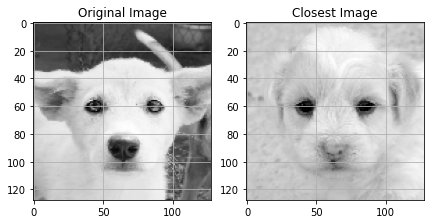

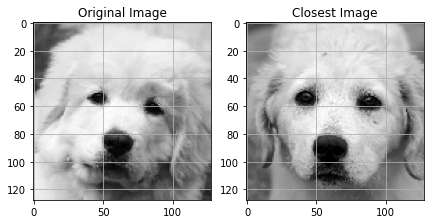

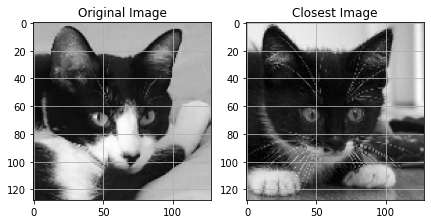

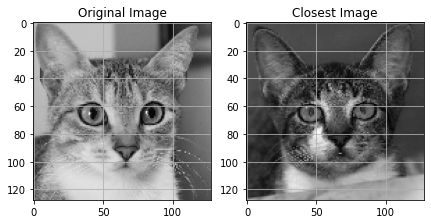

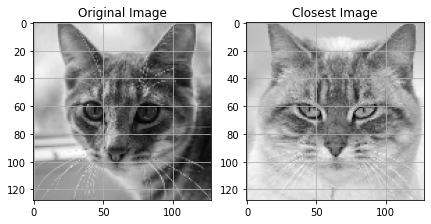

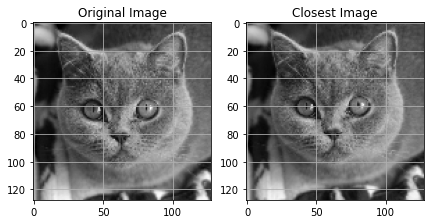

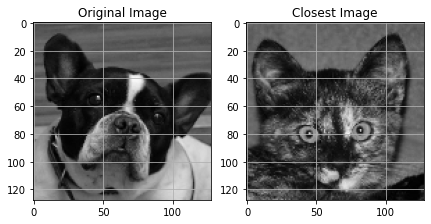

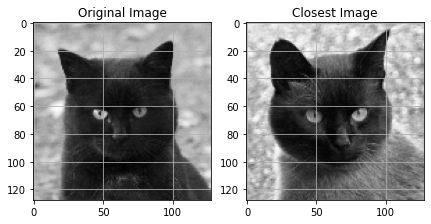

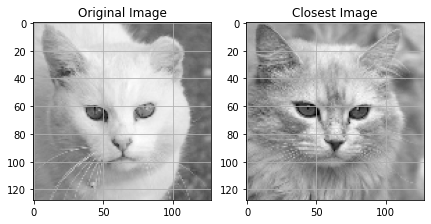

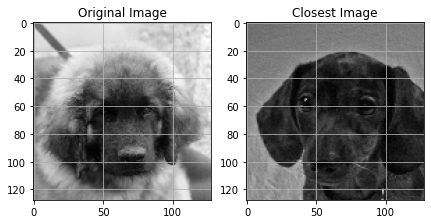

In [66]:
import copy
# find closest image to current image, try with 10 images

for _ in range(10):
    idx1 = int(np.random.rand(1)*len(df_both))
    X = df_both.to_numpy()
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)

    plt.figure(figsize=(7,10))
    plt.subplot(1,2,1)
    plt.imshow(X[idx1].reshape((h,w)), cmap='gray')
    plt.title("Original Image")
    plt.grid()

    plt.subplot(1,2,2)
    plt.imshow(X[idx2].reshape((h,w)), cmap='gray')
    plt.title("Closest Image")
    plt.grid()
    plt.show()

We can see some dogs are matched with cats. Closest image may not be the best here. Now, let's try to run real prediction with K-th Nearest Neighbor and some different number of neighbors.

In [68]:
# Split dataset to training and validating
# 0 for cat, 1 for dog
from sklearn.model_selection import train_test_split
train_cat, test_cat = train_test_split(df_cat.to_numpy(), test_size=0.2)
train_dog, test_dog = train_test_split(df_dog.to_numpy(), test_size=0.2)

train_X = np.concatenate((train_cat, train_dog))
test_X = np.concatenate((test_cat, test_dog))
train_y = np.concatenate((np.zeros(len(train_cat)), np.ones(len(train_dog))))
test_y = np.concatenate((np.zeros(len(test_cat)), np.ones(len(test_dog))))
print(len(train_X), len(test_X), len(train_y))
print(len(test_y), test_y)

3200 800 3200
800 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [59]:
# Applying DAISY to testing data
%time daisy_training = np.apply_along_axis(apply_daisy, 1, train_X, (h,w))
print(daisy_training.shape)

CPU times: user 1min 25s, sys: 3 s, total: 1min 28s
Wall time: 1min 30s
(3200, 8712)


In [ ]:
# Training and Testing with multiple number of neighbors
# Reference: Nathan's project
# https://github.com/n-wes/google_earth_image_classification/blob/master/img_analysis.ipynb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

daisy_testing = np.apply_along_axis(apply_daisy, 1, test_X, (h,w))

training_accuracy = []
test_accuracy = []
k_range = range(1,10)
neighbors_settings = k_range

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(daisy_training, train_y)
    training_accuracy.append(clf.score(daisy_training, train_y))
    test_accuracy.append(clf.score(daisy_testing, test_y))
    print(f"# Neighbors {n_neighbors} - Training score {training_accuracy[-1]} - Testing score {test_accuracy[-1]}")

plt.plot(neighbors_settings, training_accuracy, label="Training Accuracy")
plt.plot(neighbors_settings, test_accuracy, label="Testing Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("K Neighbors")
plt.legend()
plt.xticks(np.arange(min(k_range), max(k_range)+1, 1.0))
plt.show()

# Neighbors 1 - Training score 1.0 - Testing score 0.96125
# Neighbors 2 - Training score 0.813125 - Testing score 0.8025
# Neighbors 3 - Training score 0.885 - Testing score 0.865


### 4.3 Edge detection

To further the effectiveness of our k-nearest neighbors approach, we will pre-process our data by performing edge-detection algorithms on the images in our datasets before turning them into a dataframe to apply our k-nearest neighbors analysis. 

Since cats and dogs tend to have distinctive profiles (while cats tend to have pointy erect ears, most dogs have floppy ears; cats tend to have shorter snouts than dogs, etc.) and differing fur patterns (more cats tend to have striped fur as previously mentioned), we hope that by performing edge-detection image processing, we can accentuate these differences between cats and dogs before applying k-nearest neighbors.

In [ ]:
from skimage.filters import sobel_h, sobel_v

def sobel(img):
    return np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 )

def show(img, title = ''):
    plt.imshow(img, cmap='gray')
    if len(title): plt.title(title)
    plt.xticks(())
    plt.yticks(())
    plt.show()

Additionally, we perform Gaussian blur to see if the distinguishing features of an image can be further accentuated.

In [ ]:
def gaussian_blur(img):
    def gaussian_filter(img, r, c):
        kernel = 1 / 273 * np.array([[1,  4,  7,  4, 1],
                                     [4, 16, 26, 16, 4],
                                     [7, 26, 41, 26, 7],
                                     [4, 16, 26, 16, 4],
                                     [1,  4,  7,  4, 1]])
        tot = 0
        for i in range(r - 2, r + 3):
            for j in range(c - 2, c + 3):
                tot += kernel[i - r + 2][j - c + 2] * img[i][j]
        return tot
    img = img.copy()
    blurred = img
    tot = 0
    for i in range(2, img.shape[0] - 2):
        for j in range(2, img.shape[1] - 2):
            tot = gaussian_filter(img, i, j)
            blurred[i][j] = tot
    return blurred

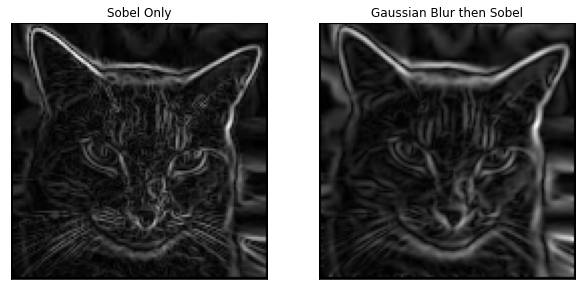

In [ ]:
img1 = np_cat[0]
sobeled_only = sobel(img1)

img2 = np_cat[0]
blurred = gaussian_blur(img2)
burred_then_sobeled = sobel(blurred)

def show_side_by_side(img1, img2, title1 = '', title2 = ''):
    plt.figure(figsize=(8, 8))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap=plt.cm.gray)
    if len(title1): plt.title(title1)
    plt.xticks(())
    plt.yticks(())
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap=plt.cm.gray)
    if len(title2): plt.title(title2)
    plt.xticks(())
    plt.yticks(())

show_side_by_side(sobeled_only, burred_then_sobeled, 'Sobel Only', 'Gaussian Blur then Sobel')

As seen from these photos, although applying Gaussian blur to an image and then performing Sobel edge detection can help reduce the noise of an image, it does not necessarily accentuate the image's distinguishing features, so much so that the reduction in blur that comes from running this algorithm justifies the computational complexity of doing so.

Thus, for the sake of reducing computational complexity of our analysis, we will perform only Sobel edge detection on our images before preparing our datasets for k-nearest neighbors.

In [ ]:
np_sobel_cats = apply_to_all(np_cats, sobel)

NameError: ignored

In [ ]:
np_sobel_dogs = apply_to_all(np_dogs, sobel)

In [ ]:
flatten_sobel_cats = apply_to_all(np_cats, flatten)
flatten_sobel_dogs = apply_to_all(np_dogs, flatten)

NameError: ignored

In [ ]:
df_sobel_cat = pd.DataFrame.from_records(flatten_cats)
df_sobel_dog = pd.DataFrame.from_records(flatten_dogs)

In [ ]:
df_stat_sobel_cat = generate_df_stat(df_cat)
df_stat_sobel_dog = generate_df_stat(df_dog)